### K-means

##### Load data

In [19]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics import davies_bouldin_score, silhouette_score
from collections import Counter
import numpy as np

# Load data
file_path_users = "Data/User Listening History.csv"
df_users = pd.read_csv(file_path_users)
file_path_songs = "Data/df_combined.csv"
df_songs = pd.read_csv(file_path_songs)

# One-hot encoding the genre column
genre_encoded = pd.get_dummies(df_songs['genre'], prefix='genre')

# Include all relevant numeric attributes
song_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 
                 'tempo', 'year']  

# Combine genre and numeric attributes
numeric_features = df_songs[song_features]
song_data = pd.concat([genre_encoded, numeric_features], axis=1)

# Standardize the data
scaler = StandardScaler()
scaled_songs = scaler.fit_transform(song_data)

##### Elbow method for finding the optimal k-value

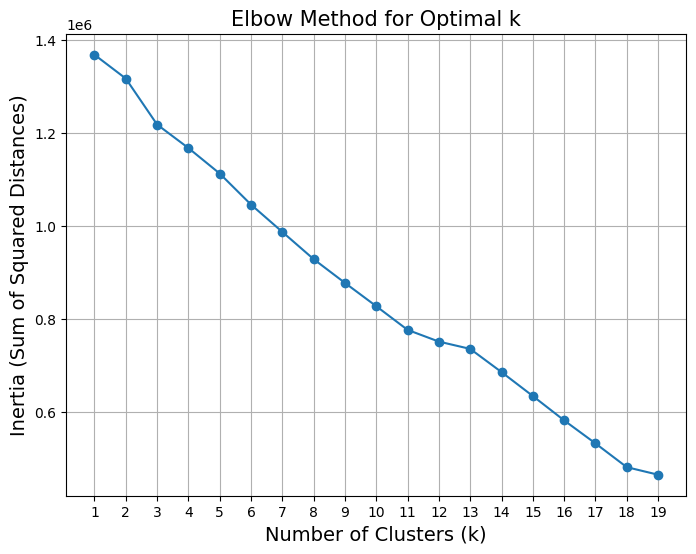

In [20]:
# Define the range of k values to test
k_values = range(1, 20)  
inertia = []  

# Perform K-Means clustering for each k and calculate inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_songs)  
    inertia.append(kmeans.inertia_)

# Plot the inertia values against k
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=15)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=14)
plt.xticks(k_values)  
plt.grid()
plt.show()

##### Calculate the Silhouette score to decide between and evaluate 3, 11 and 18 clusters

In [21]:
# For k = 3
kmeans_3 = KMeans(n_clusters=3, random_state=42).fit(scaled_songs)
silhouette_3 = silhouette_score(scaled_songs, kmeans_3.labels_)
print(f"Silhouette Score for k=3: {silhouette_3}")

# For k = 11
kmeans_11 = KMeans(n_clusters=11, random_state=42).fit(scaled_songs)
silhouette_11 = silhouette_score(scaled_songs, kmeans_11.labels_)
print(f"Silhouette Score for k=11: {silhouette_11}")

# For k = 18
kmeans_18 = KMeans(n_clusters=18, random_state=42).fit(scaled_songs)
silhouette_18 = silhouette_score(scaled_songs, kmeans_18.labels_)
print(f"Silhouette Score for k=18: {silhouette_18}")

Silhouette Score for k=3: 0.14865869388402386
Silhouette Score for k=11: 0.20663973936584748
Silhouette Score for k=18: 0.19282211870632263


##### Cluster

In [22]:
# KMeans clustering 
n_song_clusters = 11 # Chosen from Elbow Method and Silhouette score
kmeans_songs = KMeans(n_clusters=n_song_clusters, random_state=42)
df_songs['song_cluster'] = kmeans_songs.fit_predict(scaled_songs)

# Apply the song clusters on the user data
df_users = df_users.merge(df_songs[['track_id', 'song_cluster']], on='track_id', how='left')

# Group by user and song cluster and sum the playcount
user_cluster_plays = df_users.groupby(['user_id', 'song_cluster'])['playcount'].sum().reset_index()

# Create a matrix of users and song clusters
user_cluster_matrix = user_cluster_plays.pivot(index='user_id', columns='song_cluster', values='playcount').fillna(0)

# Find the cluster with the highest playcount for each user
user_cluster_matrix['most_played_cluster'] = user_cluster_matrix.idxmax(axis=1)

# Assign users the most played cluster
df_users = df_users.merge(user_cluster_matrix['most_played_cluster'], on='user_id', how='left')

# Drop song_cluster column
df_users = df_users.drop(columns=['song_cluster'], axis=1)

# Save the DataFrame to a CSV file
df_users.to_csv('Data/df_users.csv', index=False)

# Print first 5
print(df_users.head())

             track_id                                   user_id  playcount  \
0  TRIRLYL128F42539D1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
1  TRFUPBA128F934F7E1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
2  TRLQPQJ128F42AA94F  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
3  TRTUCUY128F92E1D24  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
4  TRHDDQG12903CB53EE  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   

   most_played_cluster  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  


##### Davies-Bouldin index

In [79]:
# Compute Davies-Bouldin Index
dbi = davies_bouldin_score(scaled_songs, df_songs['song_cluster'])

print(f"Davies-Bouldin Index: {dbi}")

Davies-Bouldin Index: 1.4821443342535678


##### Number of users in each cluster

most_played_cluster
0     565666
2      88505
3      81952
7      67066
4      53039
5      49191
1      44694
9       4526
6       3265
10      2779
8       1354
Name: count, dtype: int64


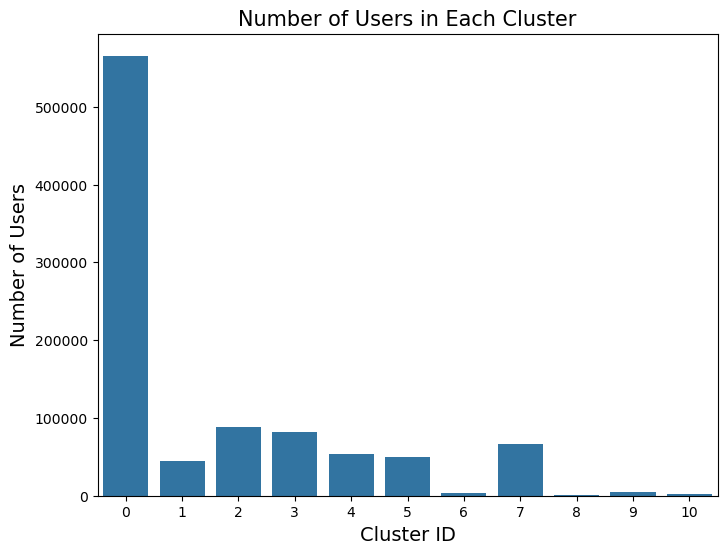

In [87]:
# Count the number of users in each most_played_cluster
cluster_counts = user_cluster_matrix['most_played_cluster'].value_counts()

# Print the results
print(cluster_counts)

# Histogram showing the distribution of users across the clusters
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Number of Users in Each Cluster', fontsize=15)
plt.xlabel('Cluster ID', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.show()

##### Characteristics of the user clusters

In [81]:
# Analyze cluster characteristics
cluster_characteristics = (
    song_data.assign(song_cluster=df_songs['song_cluster'])  
    .groupby('song_cluster')  
    .mean()  
)

# Add genre feature
genre_columns = [col for col in song_data.columns if col.startswith('genre_')]
numeric_columns = [col for col in song_data.columns if col not in genre_columns]

# Print results
print("Cluster Characteristics:")
for cluster_id in range(len(cluster_characteristics)):
    print(f"\nCluster {cluster_id} Characteristics:")
    print("Top Genres (based on mean relevance):")
    top_genres = cluster_characteristics.loc[cluster_id, genre_columns].sort_values(ascending=False).head(5)
    print(top_genres)

    print("\nTop Numeric Features (based on mean values):")
    top_numeric = cluster_characteristics.loc[cluster_id, numeric_columns].sort_values(ascending=False).head(5)
    print(top_numeric)

    print("\nLowest Numeric Features (based on mean values):")
    low_numeric = cluster_characteristics.loc[cluster_id, numeric_columns].sort_values(ascending=True).head(5)
    print(low_numeric)

Cluster Characteristics:

Cluster 0 Characteristics:
Top Genres (based on mean relevance):
genre_Rock       0.986466
genre_Jazz       0.011249
genre_Folk       0.002285
genre_Blues      0.000000
genre_Country    0.000000
Name: 0, dtype: float64

Top Numeric Features (based on mean values):
year      2004.178970
tempo      127.942078
key          5.347878
energy       0.776783
mode         0.652386
Name: 0, dtype: float64

Lowest Numeric Features (based on mean values):
loudness           -6.704395
speechiness         0.072984
acousticness        0.101193
instrumentalness    0.156118
liveness            0.226071
Name: 0, dtype: float64

Cluster 1 Characteristics:
Top Genres (based on mean relevance):
genre_Metal         1.0
genre_Blues         0.0
genre_Country       0.0
genre_Electronic    0.0
genre_Folk          0.0
Name: 1, dtype: float64

Top Numeric Features (based on mean values):
year      2003.890416
tempo      124.070694
key          5.348068
energy       0.867291
mode         

##### Word cloud plots

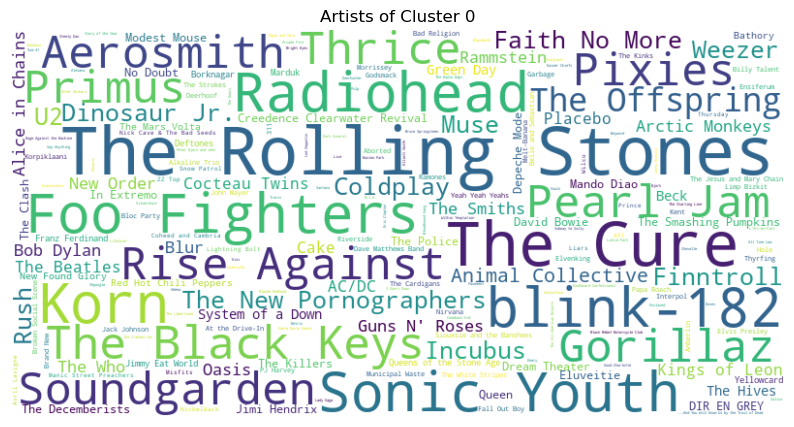

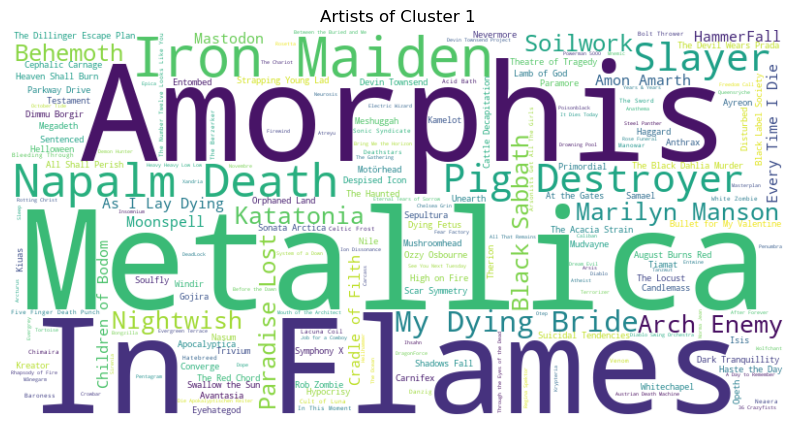

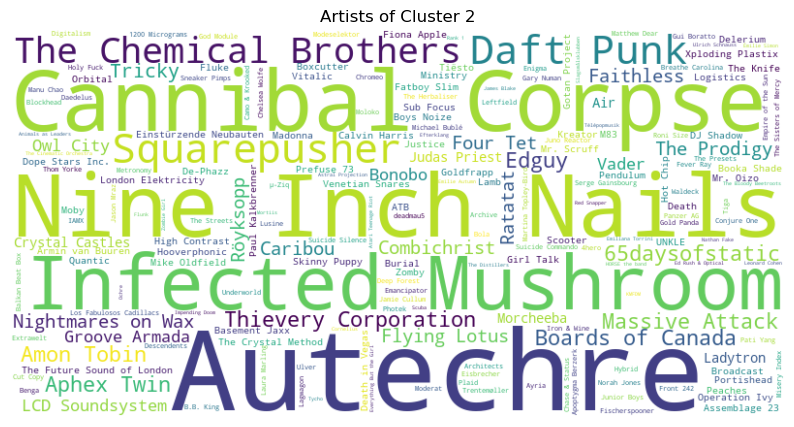

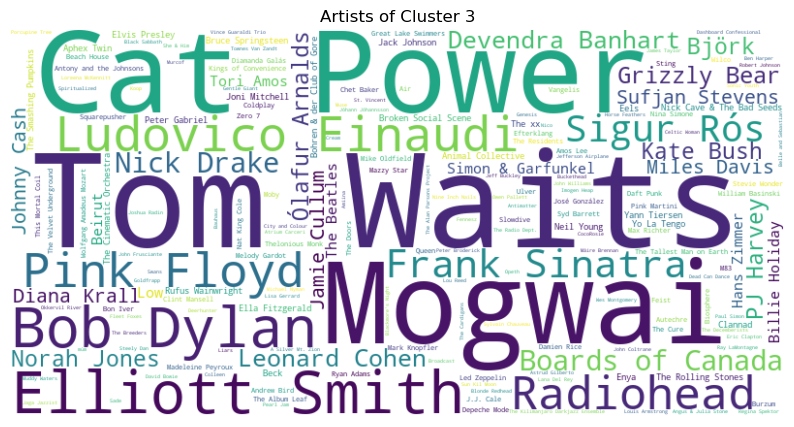

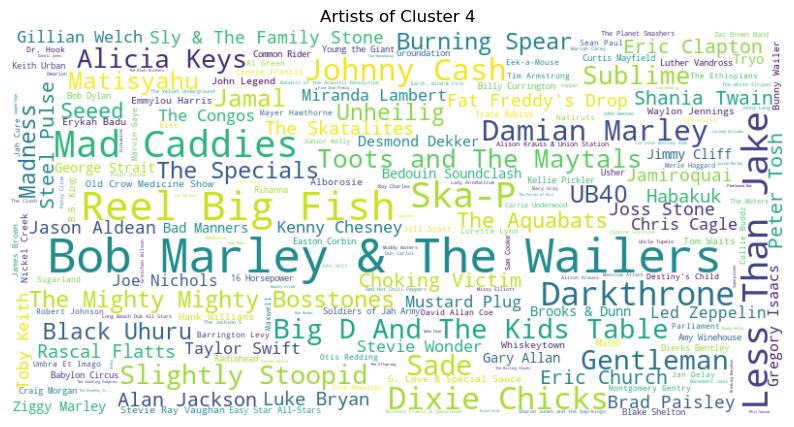

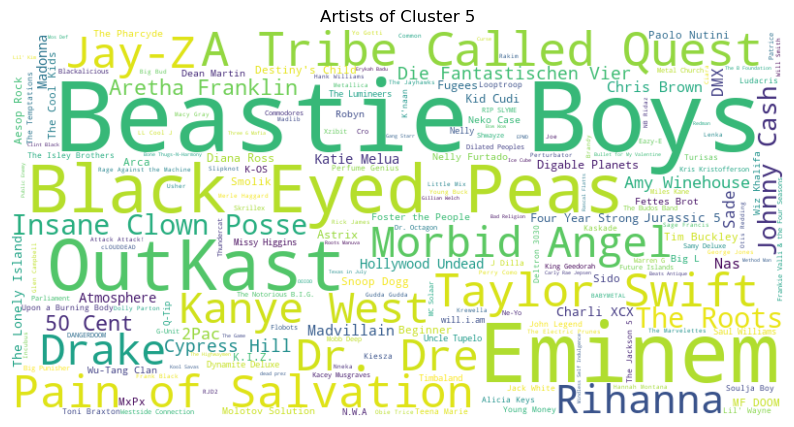

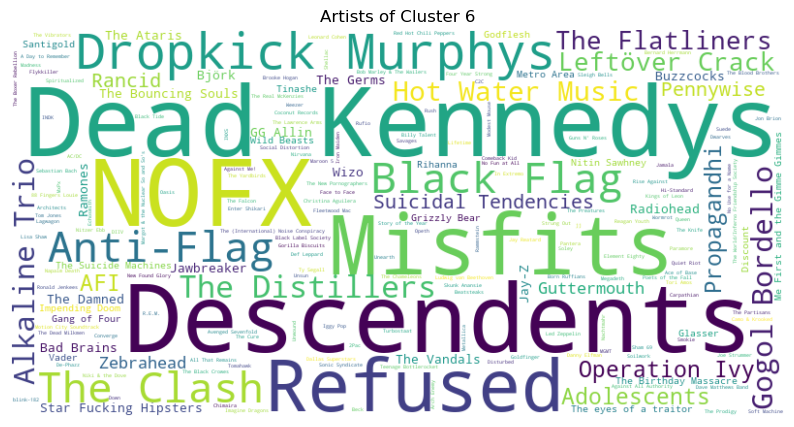

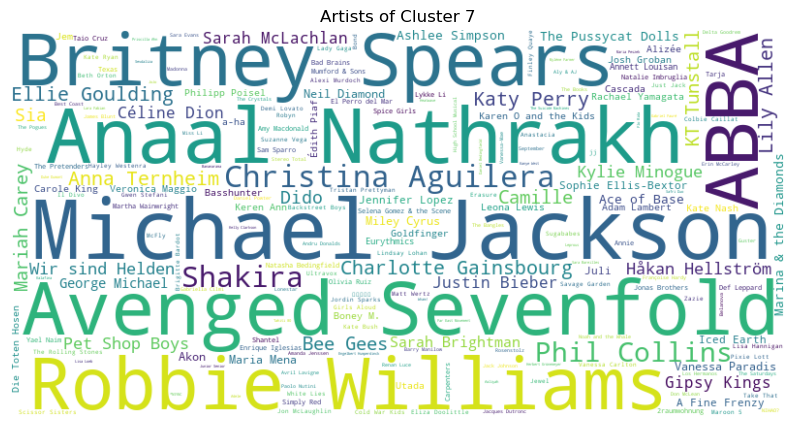

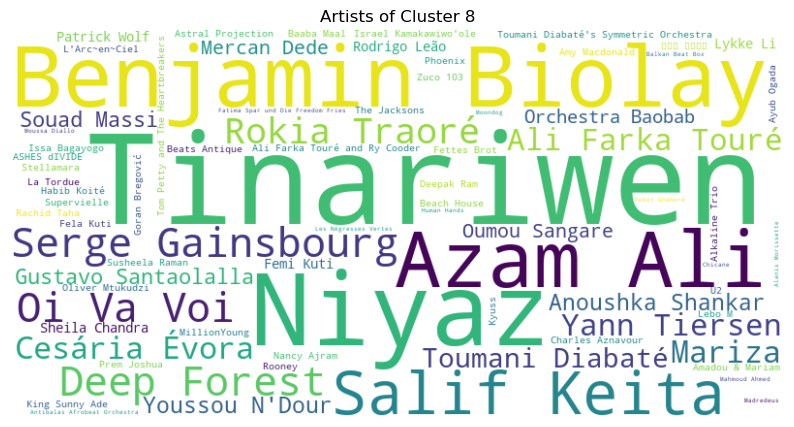

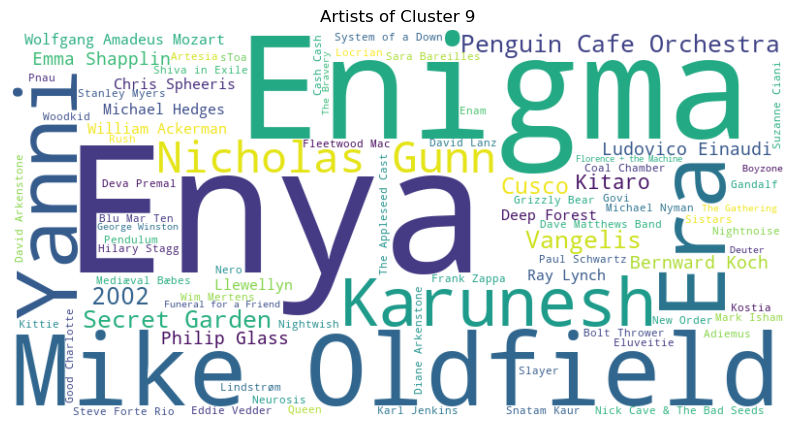

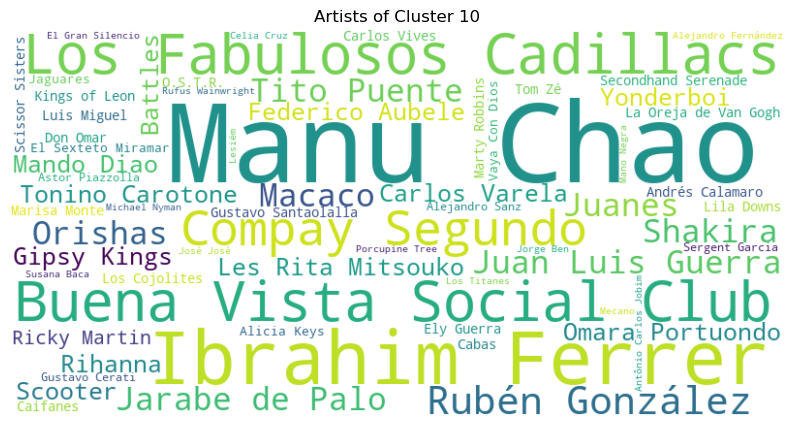

In [82]:
# Create artist word plots for all 15 clusters
for cluster_id in range(11):  
    # Filter songs belonging to the current cluster
    cluster_songs = df_songs[df_songs['song_cluster'] == cluster_id]

    # Count the occurrences of each artist in the cluster
    artist_counts = cluster_songs['artist'].value_counts()

    # Create a dictionary for WordCloud
    artist_dict = artist_counts.to_dict()

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(artist_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Artists of Cluster {cluster_id}")
    plt.show()

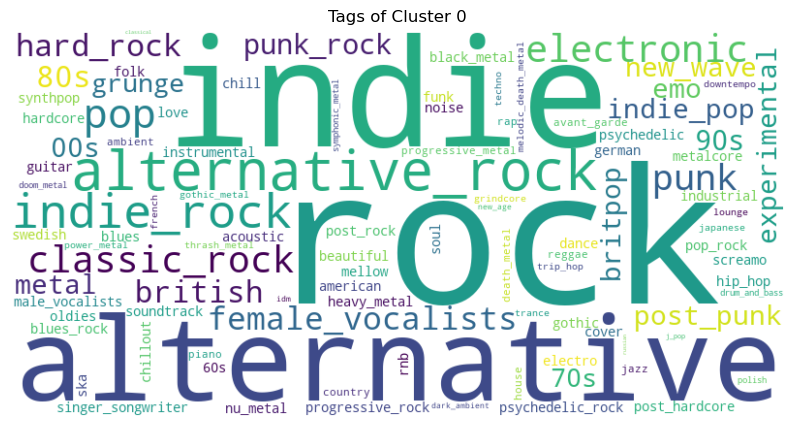

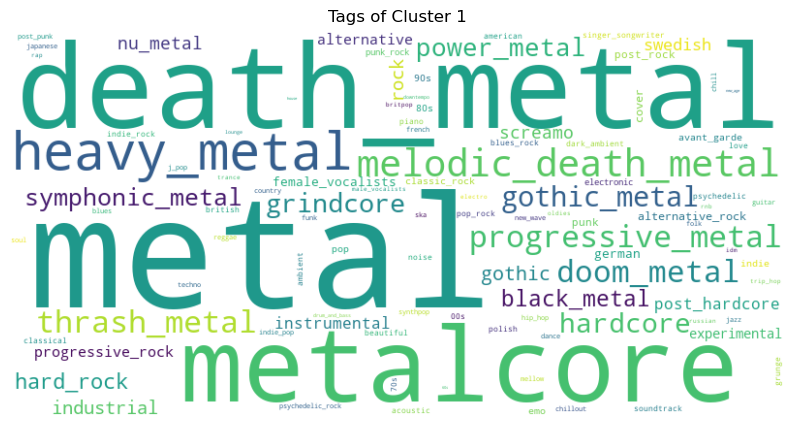

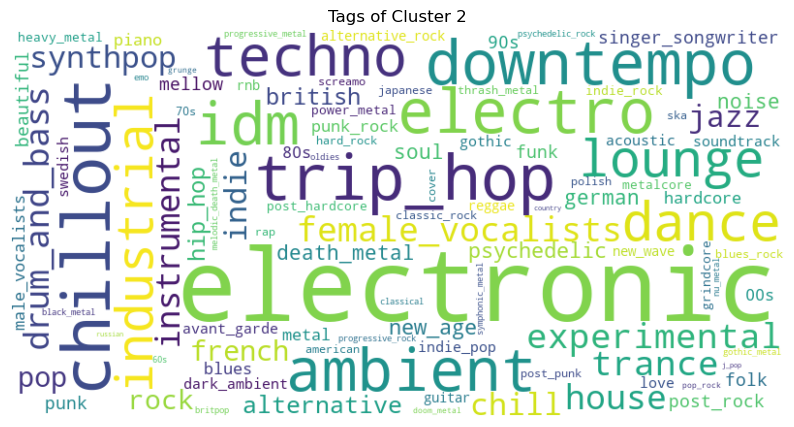

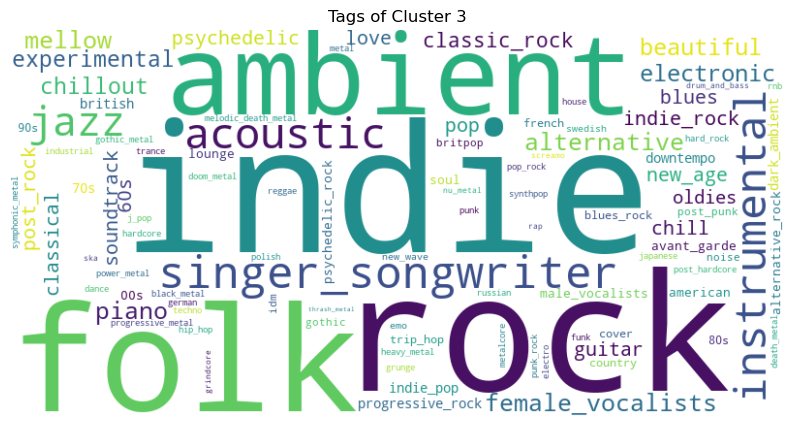

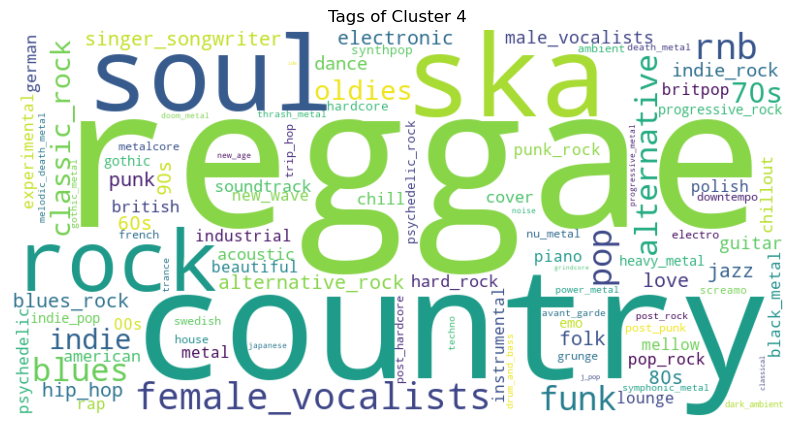

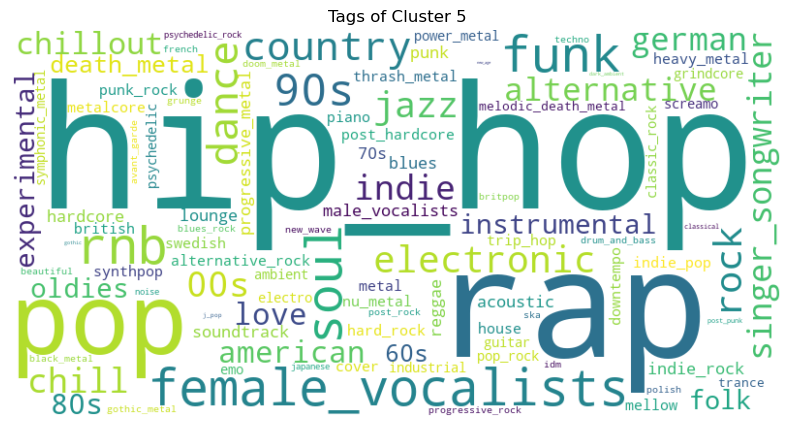

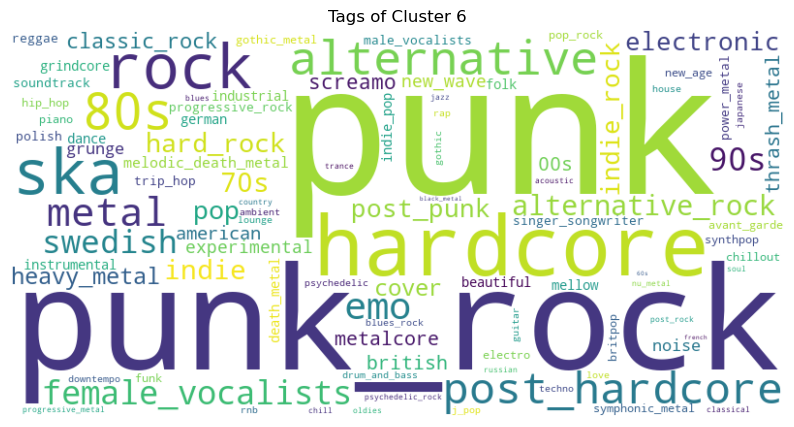

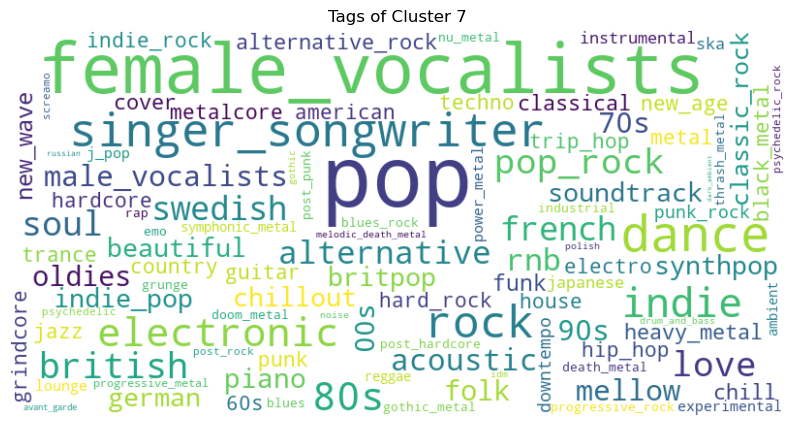

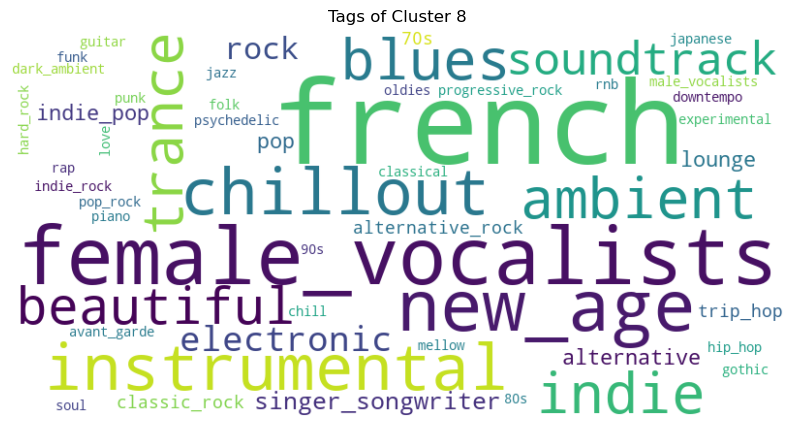

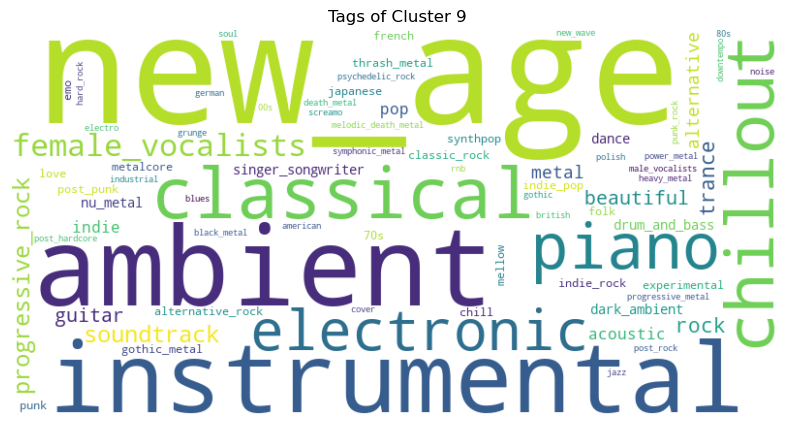

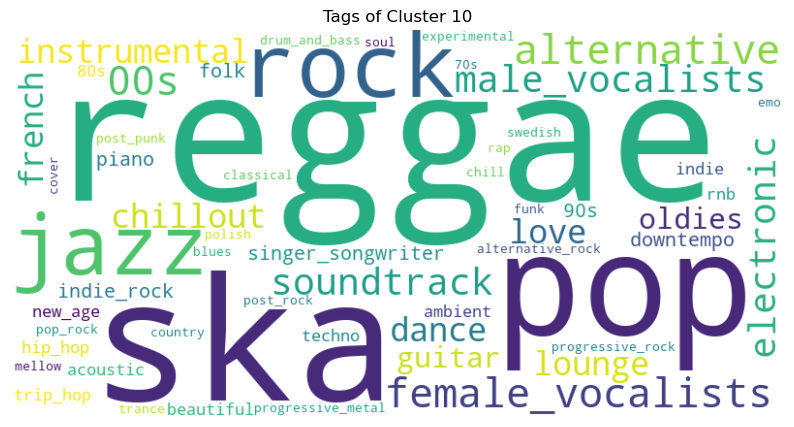

In [83]:
# Create tags word plots for all 15 clusters
for cluster_id in range(11):  
    # Filter songs belonging to the current cluster
    cluster_songs = df_songs[df_songs['song_cluster'] == cluster_id]

    # Combine all tags in the cluster
    all_tags = cluster_songs['tags'].dropna().str.cat(sep=', ')  
    tag_list = [tag.strip() for tag in all_tags.split(',')]  

    # Count the frequency of each tag
    tag_counts = Counter(tag_list)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tag_counts)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Tags of Cluster {cluster_id}")
    plt.show()

##### Songs that represent each cluster

In [84]:
# Calculate the distance of each song to its cluster centroid
cluster_centroids = kmeans_songs.cluster_centers_  
song_distances = np.linalg.norm(scaled_songs - cluster_centroids[df_songs['song_cluster']], axis=1)

# Add the distances as a column to df_songs
df_songs['distance_to_centroid'] = song_distances

# For each cluster, find the top N closest songs
N = 5  
representative_songs = []

for cluster_id in range(n_song_clusters):
    # Filter songs belonging to the current cluster
    cluster_songs = df_songs[df_songs['song_cluster'] == cluster_id]
    
    # Sort by distance to centroid
    closest_songs = cluster_songs.nsmallest(N, 'distance_to_centroid')
    
    # Add to the representative songs list
    representative_songs.append(closest_songs[['track_id', 'distance_to_centroid']])

    print(f"\nCluster {cluster_id} Representative Songs:")
    print(closest_songs[['track_id', 'distance_to_centroid', 'name', 'year', 'artist', 'genre']])



Cluster 0 Representative Songs:
                 track_id  distance_to_centroid                        name  \
21817  TRZHXTM128F424DA16              1.132464             American Gigolo   
30502  TRULBIF128F4232AEC              1.140903                      Genius   
28162  TRRYHJZ128F931451F              1.155595                    Conquest   
19339  TRXWFEP128F92E4AED              1.183990             Mother Superior   
49637  TRIUCQG128F932C14B              1.231414  Growing Old Is Getting Old   

       year              artist genre  
21817  2002              Weezer  Rock  
30502  2003       Kings of Leon  Rock  
28162  2007   The White Stripes  Rock  
19339  2007  Coheed and Cambria  Rock  
49637  2009   Silversun Pickups  Rock  

Cluster 1 Representative Songs:
                 track_id  distance_to_centroid                    name  year  \
41279  TRNIKUC128F9344C36              1.297033          Barael's Blade  2006   
38052  TRXLNCD128F9344C43              1.353385  Lament f

##### Plot the clusters

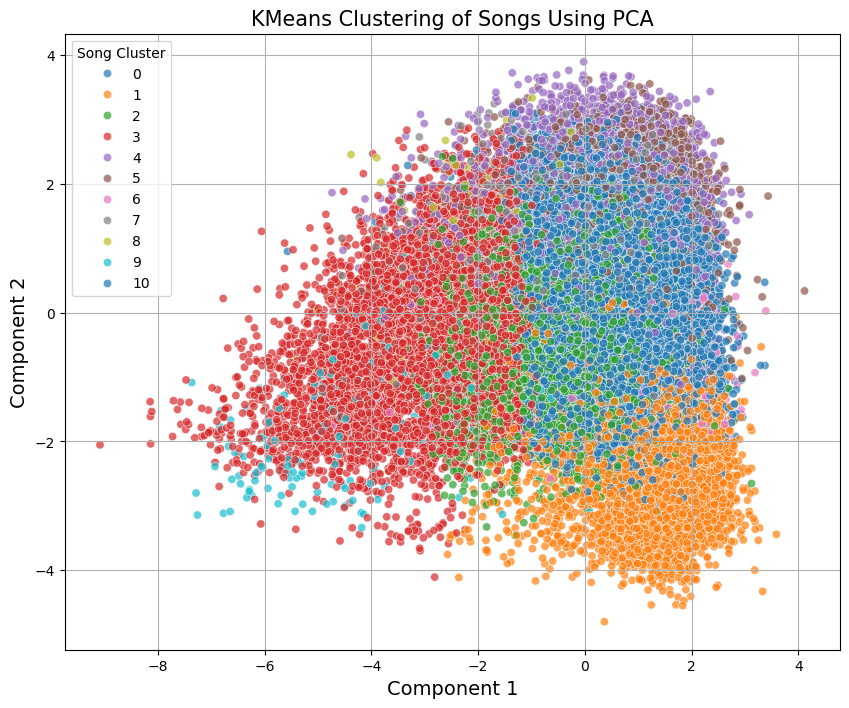

In [85]:
# Apply KMeans clustering to the songs
n_song_clusters = 11  
kmeans_songs = KMeans(n_clusters=n_song_clusters, random_state=42)
df_songs['song_cluster'] = kmeans_songs.fit_predict(scaled_songs)

# Reduce original dimension to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(scaled_songs)

# Create a DataFrame for visualization
cluster_vis_df_pca = pd.DataFrame(reduced_features_pca, columns=['Component 1', 'Component 2'])
cluster_vis_df_pca['Cluster'] = df_songs['song_cluster']

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=cluster_vis_df_pca, 
    x='Component 1', 
    y='Component 2', 
    hue='Cluster', 
    palette='tab10', 
    alpha=0.7
)
plt.title('KMeans Clustering of Songs Using PCA', fontsize=15)
plt.xlabel('Component 1', fontsize=14)
plt.ylabel('Component 2', fontsize=14)
plt.legend(title='Song Cluster', loc='best')
plt.grid(True)
plt.show()